## E4-11. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

### 1) 데이터 준비와 확인

----

In [34]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2) 데이터로더 구성

실습때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴


In [35]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']


def load_data(train_data, test_data, num_words=10000):    
    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복제거
    train_data = train_data.dropna(how = 'any') # nan 제거
    test_data.drop_duplicates(subset=['document'], inplace=True) # 중복제거
    test_data = test_data.dropna(how = 'any') #na 제거

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index


In [36]:
#### 데이터 로더 고고 
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print(len(X_train))

146182


In [37]:
# 워드 익덱서 생성
index_to_word = {index:word for word, index in word_to_index.items()}
print(len(index_to_word))


10000


In [38]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [39]:
# 들어왔늕비 확인
print(len(word_to_index))

10000


### 3) 모델구성을 위한 데이터 분석 및 가공
----

* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [40]:
# 데이터셋 내 문장 길이 분포
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.969355837799927
문장길이 최대 :  116
문장길이 표준편차 :  12.843536204665021


In [41]:
# 적절한 최대 문장 길이 지정
max_tokens = np.mean(num_tokens) + 2.5 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  48
전체 문장의 0.9548784420929768%가 maxlen 설정값 이내에 포함됩니다. 


In [42]:
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

In [43]:
# 중간 점검
print(X_train.shape)
print(X_test.shape)

(146182, 48)
(49157, 48)


### 4) 모델구성 및 validation set 구성
----
* 모델은 3가지 이상 다양하게 구성하여 실험해 보세요. 

In [44]:
# validation set 30000건 분리
x_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지
partial_x_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(x_val.shape)
print(y_val.shape)
print(partial_x_train.shape)
print(partial_y_train.shape)

(30000, 48)
(30000,)
(116182, 48)
(116182,)


###  LSTM 모델


In [45]:
vocab_size = 10000
word_vector_dim = 128

LSTM_ = keras.Sequential()
LSTM_.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_.add(keras.layers.LSTM(128))
LSTM_.add(keras.layers.Dense(1, activation='sigmoid'))
LSTM_.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________


### 5) 모델 훈련 개시

----

In [47]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


LSTM_.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

LSTM_history = LSTM_.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    callbacks=[early, check],
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
3631/3631 [==============================] - ETA: 0s - loss: 0.3683 - accuracy: 0.8369
Epoch 00001: saving model to best_model.h5
3631/3631 [==============================] - 39s 11ms/step - loss: 0.3683 - accuracy: 0.8369 - val_loss: 0.3190 - val_accuracy: 0.8619
Epoch 2/10
3628/3631 [============================>.] - ETA: 0s - loss: 0.2816 - accuracy: 0.8815
Epoch 00002: saving model to best_model.h5
3631/3631 [==============================] - 39s 11ms/step - loss: 0.2815 - accuracy: 0.8816 - val_loss: 0.3105 - val_accuracy: 0.8648
Epoch 3/10
3630/3631 [============================>.] - ETA: 0s - loss: 0.2367 - accuracy: 0.9017
Epoch 00003: saving model to best_model.h5
3631/3631 [==============================] - 39s 11ms/step - loss: 0.2367 - accuracy: 0.9017 - val_loss: 0.3235 - val_accuracy: 0.8663
Epoch 4/10
3629/3631 [============================>.] - ETA: 0s - loss: 0.1946 - accuracy: 0.9211
Epoch 00004: saving model to best_model.h5
3631/3631 [====================

#### 학습 결과 평가

In [48]:
from tensorflow.keras.models import load_model

loaded_model = load_model('best_model.h5')
results = loaded_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5512 - accuracy: 0.8484
[0.5512405037879944, 0.8483633995056152]


### 6) Loss, Accuracy 그래프 시각화

----

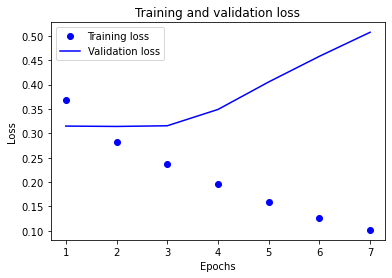

In [15]:
LSTM_history_dict = LSTM_history.history

# Loss 시각화
acc = LSTM_history_dict['accuracy']
val_acc = LSTM_history_dict['val_accuracy']
loss = LSTM_history_dict['loss']
val_loss = LSTM_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

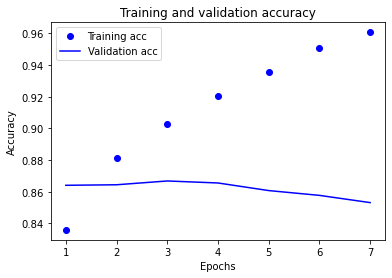

In [16]:
plt.clf()

# Accuracy 시각화
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석

In [17]:
embedding_layer = LSTM_.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 128)


In [18]:
import os


word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/LSTMword2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = LSTM_.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [19]:
import gensim
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['교도소']
vector


array([-0.13495615,  0.09095847, -0.04957052, -0.01039163,  0.08832391,
       -0.07632322, -0.12977421,  0.05807883,  0.16771114, -0.08976286,
        0.05594172, -0.12001204,  0.19397885,  0.02878937, -0.05208716,
        0.0725332 , -0.11548868, -0.14942405,  0.14485495,  0.35012528,
        0.00993444,  0.16011478, -0.04403044,  0.01401998, -0.01902145,
       -0.03429718, -0.08725236,  0.10197768,  0.04674851,  0.01064528,
        0.22456639, -0.31209654, -0.08437045, -0.16891806, -0.01467618,
       -0.00072038,  0.12311769,  0.04929126, -0.08188948, -0.13674244,
        0.10427415,  0.02723319, -0.05203216, -0.03078255,  0.04273468,
       -0.13482392, -0.13055918,  0.12580228, -0.15235305, -0.05624034,
       -0.0565136 , -0.18814826, -0.17664388, -0.07902806, -0.15292372,
        0.0133472 , -0.20011891,  0.05272816,  0.11390138, -0.15580972,
       -0.11418694,  0.00916424, -0.20316838,  0.0860908 , -0.10662357,
       -0.07197125, -0.02199711, -0.02361841,  0.1400979 , -0.22

In [20]:
#워드벡터 체크
word_vectors.similar_by_word("교도소")

[('의상', 0.804226815700531),
 ('김수현', 0.7891947031021118),
 ('목표', 0.7865188717842102),
 ('근대', 0.7842594385147095),
 ('터져서', 0.7823781967163086),
 ('기도', 0.7811053991317749),
 ('미워할', 0.7786776423454285),
 ('톱스타', 0.77662593126297),
 ('따질', 0.7631164193153381),
 ('곧', 0.7588523626327515)]

### 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

In [21]:
import gensim

#바이너리 파일 읽을려고 하다가 실패하고 TSV로 태세 전환
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin' #

#Aiffel 샘프코드는 훼이크... 였음.
word_vectors = gensim.models.Word2Vec.load(word2vec_path)
vector = word_vectors['교도소']
vector


/home/ssac15/Downloads/downloads/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([-9.13806677e-01,  1.89747643e+00, -1.35349739e+00, -8.21963474e-02,
        3.06313992e-01, -2.16287136e+00, -4.84139442e-01, -9.96844709e-01,
        1.56637728e+00, -5.81057727e-01,  2.05528307e+00,  1.44684649e+00,
        2.08032146e-01, -5.49121380e-01,  4.94153053e-01, -9.72271800e-01,
       -9.58574176e-01, -2.82881916e-01,  2.36805201e-01,  1.73390627e+00,
       -9.32426929e-01,  6.15882099e-01,  1.00543487e+00, -8.79442990e-02,
       -1.03616977e+00, -2.93409181e+00,  6.14461184e-01,  1.22445667e+00,
       -8.06004167e-01,  4.41187590e-01,  3.80589575e-01, -2.49958962e-01,
       -2.38243192e-01, -1.00419128e+00,  8.50401521e-01, -5.12514353e-01,
        3.24396998e-01,  1.31700248e-01,  9.82230902e-01,  7.60160536e-02,
        4.09986854e-01,  1.78525969e-01, -1.54977202e+00, -2.37669468e-01,
       -2.38106702e-03, -1.65516227e-01,  7.06166089e-01,  4.03973848e-01,
       -5.40422387e-02, -1.23820528e-01,  2.55524069e-01,  1.82339594e-01,
        8.59276533e-01, -

In [22]:
word_vectors.similar_by_word("사랑")


/home/ssac15/Downloads/downloads/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077906608582),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458413600921631),
 ('이별', 0.63347989320755),
 ('추억', 0.6320936679840088),
 ('인생', 0.6216273903846741),
 ('애정', 0.6206068992614746),
 ('연인', 0.6186062693595886),
 ('유혹', 0.5965287685394287)]

In [23]:
vocab_size = 10000
word_vector_dim = 200  #128 SHAPE에서 200으로 조정

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors:
        embedding_matrix[i] = word_vectors[index_to_word[i]]
        

#DeprecationWaring은 무시하자.. 곧 없어진다는 경고 인듯.. 에러는 아님.

/home/ssac15/Downloads/downloads/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/home/ssac15/Downloads/downloads/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  



# 2차 글로벌 맥스 풀링 모델 

In [24]:
from tensorflow.keras.initializers import Constant


GMP_model_ko = keras.Sequential()
GMP_model_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
GMP_model_ko.add(keras.layers.GlobalMaxPooling1D())
GMP_model_ko.add(keras.layers.Dense(8, activation='relu'))
GMP_model_ko.add(keras.layers.Dense(1, activation='sigmoid'))

In [25]:
GMP_model_ko.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 48, 200)           2000000   
_________________________________________________________________
global_max_pooling1d (Global (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


## 훈련 고고

In [26]:
GMP_model_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [27]:
history = GMP_model_ko.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
3631/3631 [==============================] - 52s 14ms/step - loss: 0.5472 - accuracy: 0.7087 - val_loss: 0.4573 - val_accuracy: 0.7839
Epoch 2/20
3631/3631 [==============================] - 51s 14ms/step - loss: 0.4136 - accuracy: 0.8107 - val_loss: 0.4068 - val_accuracy: 0.8128
Epoch 3/20
3631/3631 [==============================] - 50s 14ms/step - loss: 0.3652 - accuracy: 0.8388 - val_loss: 0.3845 - val_accuracy: 0.8286
Epoch 4/20
3631/3631 [==============================] - 50s 14ms/step - loss: 0.3303 - accuracy: 0.8578 - val_loss: 0.3816 - val_accuracy: 0.8301
Epoch 5/20
3631/3631 [==============================] - 50s 14ms/step - loss: 0.3017 - accuracy: 0.8716 - val_loss: 0.3768 - val_accuracy: 0.8363
Epoch 6/20
3631/3631 [==============================] - 50s 14ms/step - loss: 0.2767 - accuracy: 0.8853 - val_loss: 0.3793 - val_accuracy: 0.8372
Epoch 7/20
3631/3631 [==============================] - 50s 14ms/step - loss: 0.2545 - accuracy: 0.8959 - val_loss: 0.3962 -

In [28]:
results = GMP_model_ko.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.8408 - accuracy: 0.8091
[0.8407729864120483, 0.8091014623641968]


# 3차 CONV 1D  모델 

In [29]:
vocab_size = 10000
word_vector_dim = 200

conv1d_model = keras.Sequential()
conv1d_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix), input_shape=(None,)))
conv1d_model.add(keras.layers.Conv1D(64, 7, activation='relu'))
conv1d_model.add(keras.layers.MaxPooling1D(5))
conv1d_model.add(keras.layers.Conv1D(64, 7, activation='relu'))
conv1d_model.add(keras.layers.GlobalMaxPooling1D())
conv1d_model.add(keras.layers.Dense(128, activation='relu'))
conv1d_model.add(keras.layers.Dense(1, activation='sigmoid'))


In [30]:
conv1d_model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          89664     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          28736     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

## 마지막 훈련 고고

In [31]:
# Train
conv1d_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

conv1d_history = conv1d_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
1816/1816 [==============================] - 34s 18ms/step - loss: 0.4788 - accuracy: 0.7618 - val_loss: 0.3989 - val_accuracy: 0.8125
Epoch 2/20
1816/1816 [==============================] - 29s 16ms/step - loss: 0.3638 - accuracy: 0.8336 - val_loss: 0.3804 - val_accuracy: 0.8220
Epoch 3/20
1816/1816 [==============================] - 28s 15ms/step - loss: 0.3149 - accuracy: 0.8598 - val_loss: 0.3958 - val_accuracy: 0.8235
Epoch 4/20
1816/1816 [==============================] - 27s 15ms/step - loss: 0.2707 - accuracy: 0.8812 - val_loss: 0.4137 - val_accuracy: 0.8236
Epoch 5/20
1816/1816 [==============================] - 28s 15ms/step - loss: 0.2286 - accuracy: 0.9011 - val_loss: 0.4538 - val_accuracy: 0.8177
Epoch 6/20
1816/1816 [==============================] - 27s 15ms/step - loss: 0.1884 - accuracy: 0.9188 - val_loss: 0.4910 - val_accuracy: 0.8173
Epoch 7/20
1816/1816 [==============================] - 28s 15ms/step - loss: 0.1581 - accuracy: 0.9325 - val_loss: 0.5618 -

In [32]:
results = conv1d_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 1.2476 - accuracy: 0.8026
[1.2475801706314087, 0.8026323914527893]


----

## 총평

#### 1. LSTM으로 1차 진행
1537/1537 - 2s - loss: 0.5083 - accuracy: 0.8492
[0.5083235502243042, 0.8491974472999573]


####  2. 한글 word2vec 임베딩 확인


#### 3. 글로벌 맥스풀링 모델 진행

1537/1537 - 2s - loss: 0.8408 - accuracy: 0.8091
[0.8407729864120483, 0.8091014623641968]


#### 4. Conv1D  모델 진헹
1537/1537 - 4s - loss: 1.2476 - accuracy: 0.8026
[1.2475801706314087, 0.8026323914527893]

----

#### 중간 중간에 해독되지 않는 암호들이 있어서(라이브러리 , 워드2벡 임배딩 활용 등)어려웠으나, 슬랙에 올라온 답변을 통해 해결할 수 있었다. 
#### E3 카메라 스티커 이후 Exploration 난이도가 확 높아진 느낌이었다.  
#### 루브릭 평가 기준인 85% 이상은 첫 LSTM 에서 나왔으나 하이퍼 파라미터로 추정되는 것들을 (epoch, batch, data 양) 바꿔 보았지만, 개선되지 않았다. LSTM만 디폴트 값만으로도 85% 이상의 accuracy를 보였다. 
#### 지금까지 수행한 Exploration중에 가장 어려웠지만, 개인적으론 가장 흥미로웠다. 
#### 확실히 첫 과제때보다  나아진 것 같다. 지금 아니면 언제 해 보겠냐는 마음으로 끝까지 했다.  (재미있지만.. 잠 좀 푹 자고 싶다. ) 